In [ ]:
from google.colab import files
uploaded = files.upload()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New Section

In [ ]:

!ls "/content/drive/MyDrive/Colab Notebooks/RiceLeafDataset"


'Bacterial Leaf Blight'  'Brown spot'  'Leaf Smut'


In [ ]:
import os
import numpy as np
from PIL import Image  # To handle image files
import matplotlib.pyplot as plt  # For visualization
from sklearn.model_selection import train_test_split  # For dataset splitting
import tensorflow as tf  # For deep learning model
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For data augmentation



In [ ]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/RiceLeafDataset"


In [ ]:
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        print(f"Class: {folder}, Number of images: {len(os.listdir(folder_path))}")


Class: Bacterial Leaf Blight, Number of images: 37
Class: Leaf Smut, Number of images: 39
Class: Brown spot, Number of images: 40


## Load Image with array


In [ ]:
# Load Image with array
target_size = (224, 224)  # Standard image size for models like CNN
images = []
labels = []

class_labels = {folder: idx for idx, folder in enumerate(os.listdir(dataset_path))}
print("Class to Label Mapping:", class_labels)

for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            img = Image.open(img_path).resize(target_size)
            images.append(np.array(img))
            labels.append(class_labels[class_name])

# Convert to NumPy arrays
images = np.array(images)
labels = np.array(labels)

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


Class to Label Mapping: {'Bacterial Leaf Blight': 0, 'Leaf Smut': 1, 'Brown spot': 2}
Images shape: (116, 224, 224, 3)
Labels shape: (116,)


## Split Dataset

In [ ]:
#Split Dataset
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 81
Validation set size: 17
Test set size: 18


## Normalize Image

In [ ]:
#Normalize image
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0


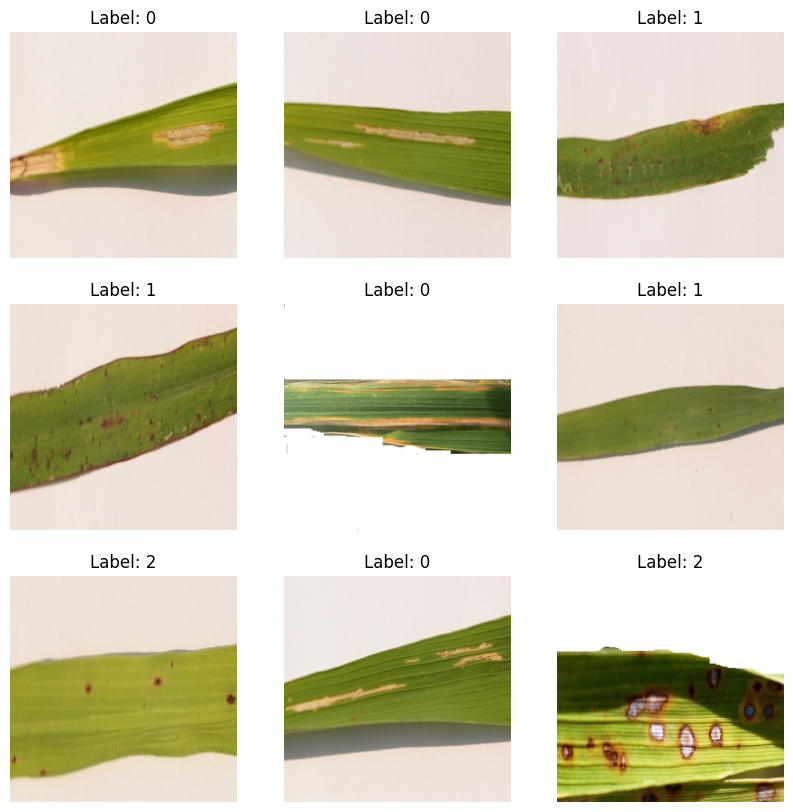

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow((X_train[i] * 255).astype("uint8"))  # Scale back to 0-255
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object for training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    rotation_range=40,       # Random rotations in the range 0-40 degrees
    width_shift_range=0.2,   # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,         # Shearing transformation
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Random horizontal flip
    fill_mode='nearest'      # Fill any empty pixels after transformation
)

# Apply the transformations to your training images
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)


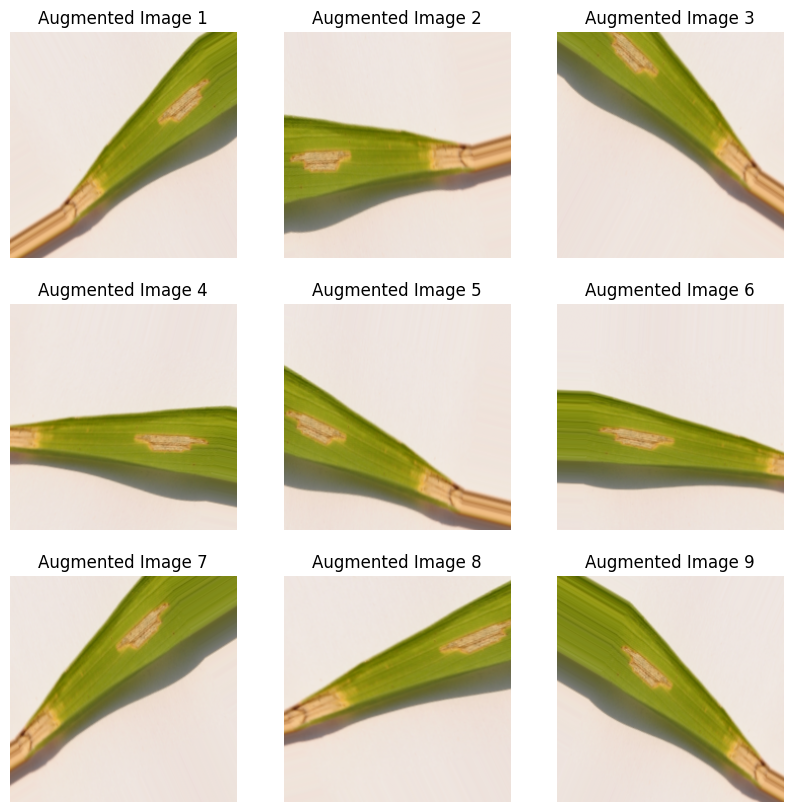

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Initialize the ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize to [0, 1] range for augmentation
    rotation_range=40,       # Random rotations in the range 0-40 degrees
    width_shift_range=0.2,   # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,         # Shearing transformation
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Random horizontal flip
    fill_mode='nearest'      # Fill any empty pixels after transformation
)

# Select an image from the training set for augmentation
augmented_images = [train_datagen.random_transform(X_train[0]) for _ in range(9)]

# Plot the augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])  # The images are now in the [0, 1] range
    plt.title(f"Augmented Image {i + 1}")
    plt.axis("off")
plt.show()


In [ ]:
# Transfer Learning
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models

# Load the pre-trained MobileNet model without the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model to retain pre-learned features
base_model.trainable = False

# Add a custom top layer for your problem
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes: LeafSmut, BrownSpot, BacterialBlight
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using the augmented data
model.fit(train_generator, epochs=10, validation_data=(X_val, y_val))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3479 - loss: 1.2122 - val_accuracy: 0.2353 - val_loss: 1.5541
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.2688 - loss: 1.1269 - val_accuracy: 0.1765 - val_loss: 1.5565
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3470 - loss: 1.1312 - val_accuracy: 0.2353 - val_loss: 1.5161
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3665 - loss: 1.1021 - val_accuracy: 0.2941 - val_loss: 1.5071
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3467 - loss: 1.1015 - val_accuracy: 0.4118 - val_loss: 1.5355
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3823 - loss: 1.0971 - val_accuracy: 0.4118 - val_loss: 1.5419
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3382 - loss: 1.1096 - val_accuracy: 0.2941 - val_loss: 1.5298
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3670 - loss: 1.0987 - val_accuracy: 0.1765 - val_loss: 1.5098
Epoch 9/10
3/3 ━━━━━━━━━━━

In [ ]:
#Normalization
X_train_mean = np.mean(X_train, axis=(0, 1, 2))  # Mean of pixel values
X_train_std = np.std(X_train, axis=(0, 1, 2))    # Standard deviation of pixel values

# Standardize the training images
X_train_standardized = (X_train - X_train_mean) / X_train_std


In [ ]:
#Early Stopping and Model Checkpoints
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping and model checkpoint callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Fit the model with the callbacks
model.fit(train_generator, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping, checkpoint])



Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2993 - loss: 1.1012 - val_accuracy: 0.4118 - val_loss: 1.5383
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3428 - loss: 1.1108 - val_accuracy: 0.4118 - val_loss: 1.5529
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3275 - loss: 1.1211 - val_accuracy: 0.4118 - val_loss: 1.5219
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3145 - loss: 1.0956 - val_accuracy: 0.4118 - val_loss: 1.4844
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.3591 - loss: 1.1018 - val_accuracy: 0.2941 - val_loss: 1.4832
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3860 - loss: 1.0950 - val_accuracy: 0.3529 - val_loss: 1.4911
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3431 - loss: 1.0962 - val_accuracy: 0.4118 - val_loss: 1.5200
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.3486 - loss: 1.0978 - val_accuracy: 0.4118 - val_loss: 1.5587


In [ ]:
# Batch Normalization
from tensorflow.keras import layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),  # Apply batch normalization
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])


In [ ]:
#Model Evaluation
# Compile the model before training or evaluation
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Now you can evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5556 - loss: 1.0072
Test Loss: 1.0071916580200195, Test Accuracy: 0.5555555820465088


In [ ]:
import os

# Print the list of folders inside the dataset directory
data_dir = '/content/drive/MyDrive/Colab Notebooks/RiceLeafDataset'
print(os.listdir(data_dir))


['Bacterial Leaf Blight', 'Leaf Smut', 'Brown spot']


In [ ]:
# Check if the directory exists
data_dir = '/content/drive/MyDrive/Colab Notebooks/RiceLeafDataset'

# List the contents of the dataset directory
print("Dataset directory contents:", os.listdir(data_dir))


Dataset directory contents: ['Bacterial Leaf Blight', 'Leaf Smut', 'Brown spot']


In [ ]:
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/RiceLeafDataset'))


['Bacterial Leaf Blight', 'Leaf Smut', 'Brown spot']


In [ ]:
print(os.listdir(data_dir))


['Bacterial Leaf Blight', 'Leaf Smut', 'Brown spot']


In [ ]:
classes = ['Leaf smut', 'Brown spot', 'Bacterial leaf blight']


In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/RiceLeafDataset'



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/RiceLeafDataset"


'Bacterial Leaf Blight'  'Brown spot'  'Leaf Smut'


In [ ]:
print(os.listdir('/content/drive/MyDrive/Colab Notebooks'))



['Untitled0.ipynb', 'RiceLeafDataset', 'Copy of Rice leaf dataset .ipynb']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/RiceProject/RiceLeafDataset'


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/RiceLeafDataset"


'Bacterial Leaf Blight'  'Brown spot'  'Leaf Smut'


In [ ]:
import os
data_dir = '/content/drive/MyDrive/Colab Notebooks/RiceLeafDataset'  # Update to your dataset location
if os.path.exists(data_dir):
    print(f"Dataset directory found: {data_dir}")
    print("Subdirectories:", os.listdir(data_dir))
else:
    print(f"Dataset directory not found: {data_dir}")


Dataset directory found: /content/drive/MyDrive/Colab Notebooks/RiceLeafDataset
Subdirectories: ['Leaf Smut', 'Bacterial Leaf Blight', 'Brown spot']


In [ ]:
classes = os.listdir(data_dir)
print("Classes found:", classes)


Classes found: ['Leaf Smut', 'Bacterial Leaf Blight', 'Brown spot']


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Define the correct dataset directory
data_dir = '/content/drive/MyDrive/Colab Notebooks/RiceLeafDataset'

# Check if the directory exists and print its contents
if os.path.exists(data_dir):
    print("Dataset directory contents:", os.listdir(data_dir))
else:
    print(f"Error: Dataset directory not found: {data_dir}")
    # Handle the error, e.g., exit the script or ask the user to provide a correct path

# Update the classes list to match the actual folder names inside the dataset directory
classes = os.listdir(data_dir)  # This assumes all folders in data_dir are classes
# Remove any unwanted folders from the classes list
classes = [folder for folder in classes if os.path.isdir(os.path.join(data_dir, folder))]

print("Classes found:", classes)

# Initialize image data and labels lists
image_data = []
labels = []

# Load images and their corresponding labels
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        img = load_img(img_path, target_size=(224, 224))  # Resize to VGG16 input size
        img_array = img_to_array(img) / 255.0  # Normalize image to [0, 1]
        image_data.append(img_array)
        labels.append(classes.index(class_name))  # Assign numeric label for each class

# Convert the lists to numpy arrays
X = np.array(image_data)
y = np.array(labels)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally, you can one-hot encode the labels for categorical crossentropy
# from tensorflow.keras.utils import to_categorical
# y_train = to_categorical(y_train, num_classes=len(classes))
# y_test = to_categorical(y_test, num_classes=len(classes))

print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")


Dataset directory contents: ['Leaf Smut', 'Bacterial Leaf Blight', 'Brown spot']
Classes found: ['Leaf Smut', 'Bacterial Leaf Blight', 'Brown spot']
Training data shape: (92, 224, 224, 3), Testing data shape: (24, 224, 224, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # Assuming 3 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X and y contain your image data and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
#Data Generators

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation data generator (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
#Training the Model
# Early stopping and checkpointing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=val_datagen.flow(X_test, y_test),
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.2728 - loss: 1.1019 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 8s/step - accuracy: 0.3364 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.3770 - loss: 1.0983 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.3731 - loss: 1.0978 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3731 - loss: 1.0972 - val_accuracy: 0.3333 - val_loss: 1.0987


In [ ]:
#Common Checks
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (92, 224, 224, 3), y_train shape: (92,)
X_test shape: (24, 224, 224, 3), y_test shape: (24,)


In [ ]:
model.summary()  # To check the architecture


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,723,339 (273.60 MB)

 Trainable params: 23,907,779 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,815,560 (182.40 MB)